# Tissue Clustering


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData

In [3]:
data_path = 'D:/Image_feature_extract/data/mouse_brain/SS200000135TL_D1_with_annotation.h5ad'
adata = sc.read(data_path)

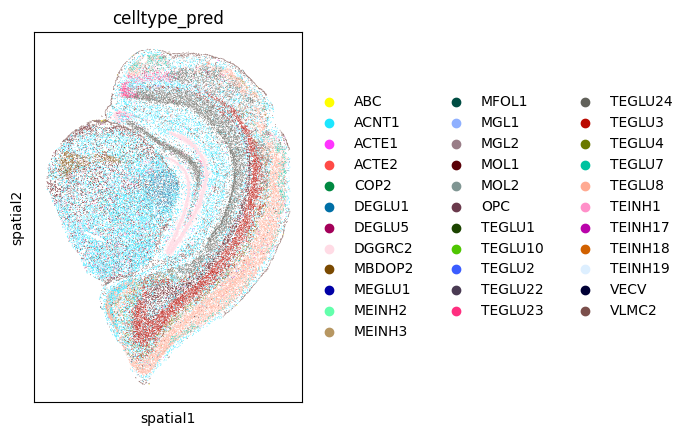

In [42]:
sc.pl.spatial(adata, color='celltype_pred', spot_size=30)

# square bin

In [14]:
def tissue_cluster(adata1, use_col, bin_size = 200, moran_thres = 0.4):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0]/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1]/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')
    
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    
    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster(adata, 'celltype_pred', bin_size = 200, moran_thres = -1)

C:\Users\caolei2\AppData\Local\Temp\ipykernel_648\3710491220.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


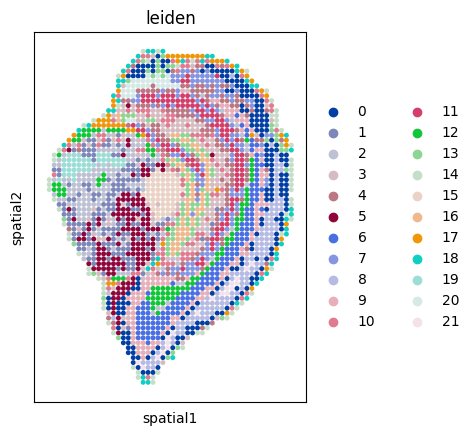

In [18]:
sc.pl.spatial(tissue, color='leiden', spot_size=1)

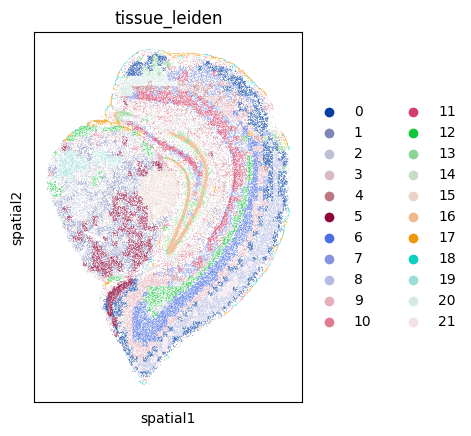

In [15]:
sc.pl.spatial(adata, color='tissue_leiden', spot_size=30)

# co-occurrence method

In [21]:
def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
    left = row[1]['Centroid_X']+l*density_thred
    right = row[1]['Centroid_X']+r*density_thred
    up = row[1]['Centroid_Y']+u*density_thred
    down = row[1]['Centroid_Y']+d*density_thred
    #print(left, right, up, down)
    tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
    tmp = tmp.groupby(by=use_col).count()
    return list(tmp['Centroid_X'])
    

def tissue_cluster_cell_res(adata1, use_col, bin_size = 200, moran_thres = 0.0):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        tmp = density_calculator(stats,use_col, row, bin_size/2, -1,1,1,-1)
        ret.append(tmp)
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = stats[use_col].cat.categories
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    sc.pp.neighbors(tissue, use_rep='spatial')
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])
    return tissue

tissue = tissue_cluster_cell_res(adata, use_col='celltype_pred', bin_size = 200, moran_thres = 0.0)

C:\Users\caolei2\AppData\Local\Temp\ipykernel_648\1131433871.py:26: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


<AxesSubplot:ylabel='Count'>

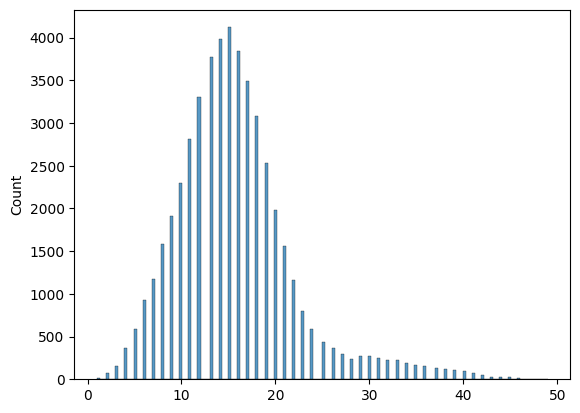

In [270]:
import seaborn as sns
sns.histplot(np.sum(tissue.X, axis=1))

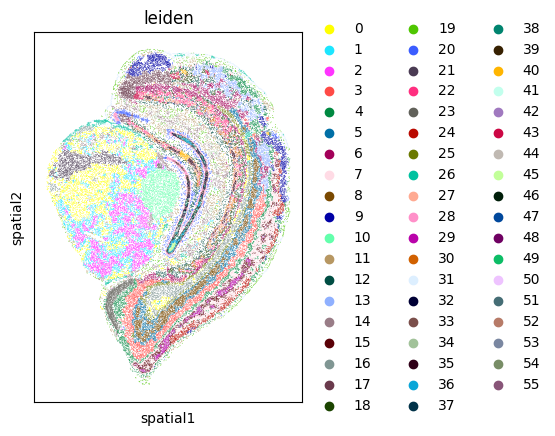

In [287]:
sc.pl.spatial(tissue, color='leiden', spot_size=30)

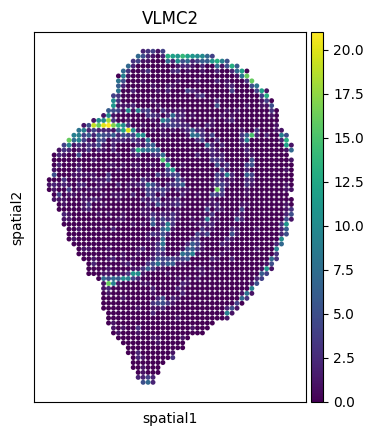

In [58]:
sc.pl.spatial(tissue, spot_size=1, color='VLMC2')

# phase position vote method

In [81]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, bias_x = 0, bias_y = 0):
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0]+bias_x)/bin_size).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1]+bias_y)/bin_size).astype(int)
    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {x:0 for x in tmp[use_col].cat.categories}
    ret = {}
    for x,y in tmp.groupby('x_y'):
        templete_dic = {x:0 for x in tmp[use_col].cat.categories}
        for z in y[use_col]:
            templete_dic[z]+=1
        ret[x] = templete_dic
    ret = pd.DataFrame(ret).T
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in ret.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    #sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata1.obs['tissue_leiden']=list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])
    #return tissue
    return list(tissue.obs.loc[adata1.obs['x_y'], 'leiden'])


In [ ]:
bias = [-50,0,50]
ret = []
for i in bias:
    for j in bias:
        tmp = tissue_cluster(adata, 'celltype_pred', bias_x = i, bias_y =j)
        ret.append(tmp)

df = pd.DataFrame(ret).T

In [2]:
df = pd.read_csv('./tissue_cluster_vote_result.csv', index_col=0).T

In [3]:
df

,0,1,2,3,4,5,6,7,8
0,14,12,18,19,16,11,20,16,17
1,14,9,15,19,12,15,20,16,17
2,14,14,16,19,12,15,20,10,21
3,14,14,16,19,12,15,20,10,21
4,7,9,15,17,16,11,9,16,17
...,...,...,...,...,...,...,...,...,...
49916,17,12,21,13,16,11,20,16,17
49917,9,9,15,13,16,11,11,16,13
49918,17,9,15,13,16,11,20,16,13
49919,14,12,21,19,16,15,20,16,17


In [61]:
def compare_cluster(cluster1, cluster2):
    #n1 = cluster1.nunique()
    #n2 = cluster2.nunique()
    #if n1 > n2:
    #    cluster1, cluster2 = cluster2, cluster1 # keep cluster1 has less clusters
    df_tmp = pd.DataFrame({'c1':cluster1, 'c2':cluster2})
    ret = {}
    for i,j in df_tmp.groupby('c2'):
        ret[i]=j.groupby('c1').count()['c2'].idxmax()
    return [ret[x] for x in cluster2]



In [62]:
center_col = df.nunique().idxmin()
ret = []
for col in df:
    ret.append(compare_cluster(df[center_col], df[col]))
ret = pd.DataFrame(ret).T

In [72]:
labels = []
for row in ret.iterrows():
    tmp = list(row[1])
    labels.append(max(tmp, key=tmp.count))
    

In [76]:
adata.obs['tmp'] = labels

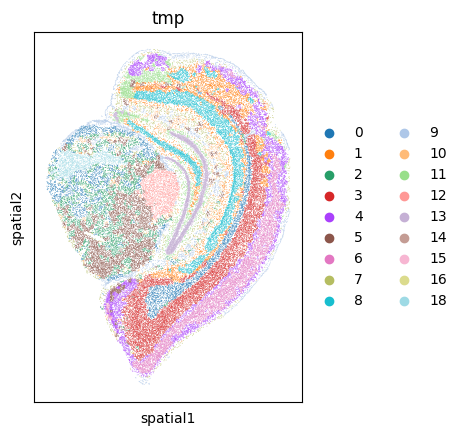

In [80]:
adata.obs['tmp'] = adata.obs['tmp'].astype('category')
sc.pl.spatial(adata, color='tmp', spot_size=30)